In [1]:
import scipy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io
from scipy import signal


In [113]:
x = (sc.io.loadmat('datasetP/P02.mat'))['data']

epochs = len(x)
# epochs = 2
electrodes = 256
measures = 201

powersDF = None

for i in range(epochs):
    epoch = pd.DataFrame(x[i])
    fourier = sc.signal.welch(epoch.loc[[7, 43, 79, 130, 184]].mean(), nperseg=measures)
    if powersDF is None:
        powersDF = pd.DataFrame(index = np.round(np.multiply(fourier[0], 100), 2))
    powersDF[i] = pd.Series(fourier[1], index = powersDF.index)


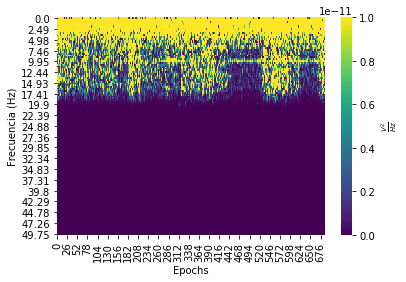

In [117]:
sns.heatmap(powersDF, cmap = 'viridis', vmin = 0, vmax = 1e-11, cbar_kws = {'label': r'$\frac{V^{2}}{Hz}$'})
plt.xlabel('Epochs')
plt.ylabel('Frecuencia (Hz)')
plt.show()
